In [1]:
!pip install torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [2]:
from torchtext.data import Field, TabularDataset, BucketIterator,LabelField
from tqdm.notebook import tqdm
from torchtext.vocab import GloVe

# Essential libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
print(torch.__version__)

2.0.1+cu118


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load the original dataset
df = pd.read_csv('missom_annotated.csv')
# df = df.rename(columns={'label_minority_stress': 'label'})
# df = df[['text', 'label']]
df = df.drop(columns=['post_id','how_annotated'])

empty_cells =  df.isnull().sum()
print(empty_cells)
df.dropna(inplace = True)

text                      0
label_minority_coping     0
label_prej_event          0
label_exp_reject          0
label_identity_conceal    0
label_internal_stigma     0
label_dysphoria           0
label_minority_stress     0
dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_ratio = 0.70
valid_ratio = 0.15
test_ratio = 0.15

train_df, remaining_df = train_test_split(df, test_size=1 - train_ratio, random_state=random.seed(SEED))
valid_df, test_df = train_test_split(remaining_df, test_size=test_ratio/(valid_ratio + test_ratio), random_state=random.seed(SEED))

# Save the dataframes to CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [6]:

TEXT = Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = LabelField(dtype = torch.float)

In [7]:
# Labels in the dataset
label_fields = [
    'label_minority_coping',
    'label_prej_event',
    'label_exp_reject',
    'label_identity_conceal',
    'label_internal_stigma',
    'label_dysphoria',
    'label_minority_stress'
]

# Create label fields for each label in multi-label classification
label_fields_objs = [LabelField(dtype=torch.float) for _ in label_fields]

In [8]:
# Load the data
train_data,valid_data, test_data = TabularDataset.splits(
    path= '/content/',
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=[('text', TEXT)] + [(label, label_field) for label, label_field in zip(label_fields, label_fields_objs)],
    skip_header=True
)
print('Number of training examples: {}'.format(len(train_data)))
print('Number of Validation examples: {}'.format(len(valid_data)))
print('Number of testing examples: {}'.format(len(test_data)))
print(train_data[0])

Number of training examples: 4052
Number of Validation examples: 868
Number of testing examples: 869


In [9]:
# TEXT.build_vocab(train_data, min_freq = 3)

MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

# Build vocab for label fields
for label_field in label_fields_objs:
    label_field.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18256.44it/s]


In [10]:
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True
    )

In [11]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

In [12]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_fields)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

The model has 4,513,535 trainable parameters
torch.Size([21998, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1475,  0.0092, -0.9416,  ..., -0.8170, -0.5505, -2.2878],
        ...,
        [ 0.3479,  1.3911,  0.6142,  ..., -0.6241,  0.3029, -0.6467],
        [-0.0177,  0.9019, -0.1703,  ..., -0.1292,  0.7746, -1.1858],
        [-0.4382, -0.3861, -0.7897,  ..., -1.5075,  1.2604,  0.2182]])


In [14]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [15]:
def multi_label_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / (len(label_fields) * len(correct))
    return acc

In [16]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text

        predictions = model(text, text_lengths)
        sigmoid_preds = torch.sigmoid(predictions)
        for i, label_field in enumerate(label_fields_objs):
                label_name = label_fields[i]
                output_1 = (sigmoid_preds[:, i] > 0.5).int()

                loss = criterion(predictions[:, i], getattr(batch, label_name))
                acc = multi_label_accuracy(predictions[:, i], getattr(batch, label_name))

                loss.backward(retain_graph=True)

                optimizer.step()

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text, text_lengths = batch.text

            predictions = model(text, text_lengths)

            sigmoid_preds = torch.sigmoid(predictions)

            for i, label_field in enumerate(label_fields_objs):
                label_name = label_fields[i]
                output_1 = (sigmoid_preds[:, i] > 0.5).int()

                loss = criterion(predictions[:, i], getattr(batch, label_name))
                acc = multi_label_accuracy(predictions[:, i], getattr(batch, label_name))

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 2.496 | Train Acc: 88.66%
	 Val. Loss: 2.366 |  Val. Acc: 88.92%
Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 2.268 | Train Acc: 89.70%
	 Val. Loss: 2.350 |  Val. Acc: 88.92%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 2.227 | Train Acc: 89.71%
	 Val. Loss: 2.333 |  Val. Acc: 88.92%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 2.179 | Train Acc: 89.70%
	 Val. Loss: 2.325 |  Val. Acc: 88.92%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 2.123 | Train Acc: 89.70%
	 Val. Loss: 2.345 |  Val. Acc: 88.78%
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 2.113 | Train Acc: 89.71%
	 Val. Loss: 2.332 |  Val. Acc: 88.68%
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 2.051 | Train Acc: 89.76%
	 Val. Loss: 2.316 |  Val. Acc: 88.73%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 2.014 | Train Acc: 89.77%
	 Val. Loss: 2.249 |  Val. Acc: 88.60%
Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 1.966 | Train Acc: 89.87%
	 Val. Loss: 2.390 |  Val. Acc: 88.15%
Epoch: 10 | Epoch T

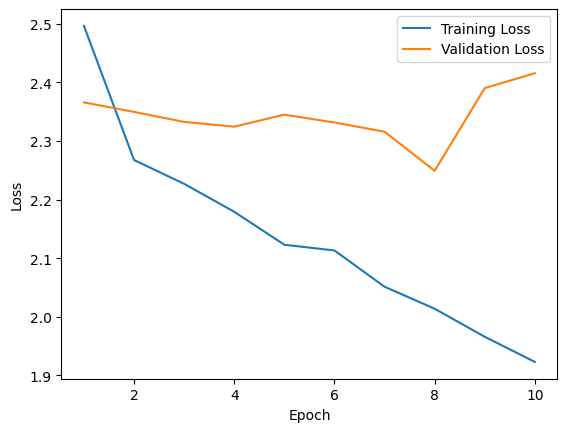

In [19]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

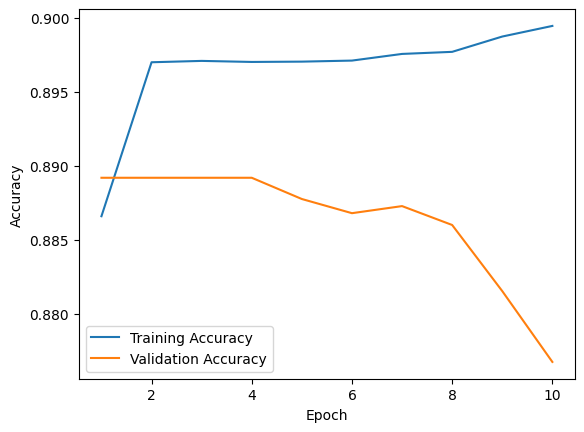

In [20]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
def calc_report(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    y_pred = [[] for _ in range(len(label_fields))]
    y_true = [[] for _ in range(len(label_fields))]
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths)
            sigmoid_preds = torch.sigmoid(predictions)
            for i, label_field in enumerate(label_fields_objs):
                label_name = label_fields[i]
                output_1 = (sigmoid_preds[:, i] > 0.5).int()
                y_pred[i].extend(output_1.tolist())
                y_true[i].extend(getattr(batch, label_name).tolist())
                loss = criterion(predictions[:, i], getattr(batch, label_name))
                acc = multi_label_accuracy(predictions[:, i], getattr(batch, label_name))
                epoch_loss += loss.item()
                epoch_acc += acc.item()
        all_reports = []
        for i, label_field in enumerate(label_fields_objs):
            rep = classification_report(y_true[i], y_pred[i], labels=[1, 0], digits=2)
            print('_________'*8)
            print(label_fields[i])
            print(rep)



In [22]:
calc_report(model, test_iterator, criterion)


________________________________________________________________________
label_minority_coping
              precision    recall  f1-score   support

           1       0.30      0.21      0.24       112
           0       0.89      0.93      0.91       757

    accuracy                           0.84       869
   macro avg       0.60      0.57      0.58       869
weighted avg       0.81      0.84      0.82       869

________________________________________________________________________
label_prej_event
              precision    recall  f1-score   support

           1       0.08      0.01      0.02        74
           0       0.91      0.99      0.95       795

    accuracy                           0.90       869
   macro avg       0.50      0.50      0.49       869
weighted avg       0.84      0.90      0.87       869

________________________________________________________________________
label_exp_reject
              precision    recall  f1-score   support

           1    